Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.







In [498]:
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [499]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
union_df = pd.concat([train, test])

In [500]:
union_df.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [501]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Категориальные признаки переводим в числовые

In [502]:
d = {'A' : 0, 'B' : 1}
# train[['Ecology_2','Ecology_3','Shops_2']] = train[['Ecology_2','Ecology_3','Shops_2']].map(d)
train['Ecology_2'] = train['Ecology_2'].map(d)
train['Ecology_3'] = train['Ecology_3'].map(d)
train['Shops_2'] = train['Shops_2'].map(d)
test['Ecology_2'] = test['Ecology_2'].map(d)
test['Ecology_3'] = test['Ecology_3'].map(d)
test['Shops_2'] = test['Shops_2'].map(d)

In [503]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


Проверим, что жилая площадь не больше чем площадь объекта недвижимости

In [504]:
train[train['Square']<train['LifeSquare']].count()

Id               482
DistrictId       482
Rooms            482
Square           482
LifeSquare       482
KitchenSquare    482
Floor            482
HouseFloor       482
HouseYear        482
Ecology_1        482
Ecology_2        482
Ecology_3        482
Social_1         482
Social_2         482
Social_3         482
Healthcare_1     169
Helthcare_2      482
Shops_1          482
Shops_2          482
Price            482
dtype: int64

In [505]:
square_median=union_df[union_df['Square']>union_df['LifeSquare']]['Square'].median()

In [506]:
life_square_median=union_df[union_df['Square']>union_df['LifeSquare']]['LifeSquare'].median()

In [507]:
ratio=square_median/life_square_median
ratio

1.5730708753907248

Заменим значения в Dataframe в строках где жилая площадь больше чем общая площадь, по среднему отношению Общая/Жилая

In [508]:
train.loc[train['Square']<train['LifeSquare'],'LifeSquare']=train['Square']/ratio
test.loc[test['Square']<test['LifeSquare'],'LifeSquare']=test['Square']/ratio

In [509]:
train[train['Square']<train['LifeSquare']].count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [510]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


Заполним жилую площадь в строках содержащие нулевое значение для жмлой площади

In [511]:
train.loc[train['LifeSquare'].isnull(),'LifeSquare']=train['Square']/ratio
test.loc[test['LifeSquare'].isnull(),'LifeSquare']=test['Square']/ratio

In [512]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


In [513]:
house_year_median=union_df[union_df['HouseYear']<2023]['HouseYear'].median()

проверим что год постройки не больше чем текущий и заменим средним значением 

In [514]:
train.loc[train['HouseYear']>2022,'HouseYear']=house_year_median
test.loc[test['HouseYear']>2022,'HouseYear']=house_year_median

In [515]:
health_care_median=union_df['Healthcare_1'].median()

Заменим строки с пустами значениями наличия объектов зравоохранения, среним значением

In [516]:
train.loc[train['Healthcare_1'].isnull(),'Healthcare_1']=health_care_median
test.loc[test['Healthcare_1'].isnull(),'Healthcare_1']=health_care_median

In [517]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


In [518]:
fearute_names=[ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']

In [519]:
X_train=train[fearute_names]
X_test=test[fearute_names]

In [520]:
Y_train=train['Price']


Построим матрицу ковариации признаков

In [521]:
import seaborn as sns

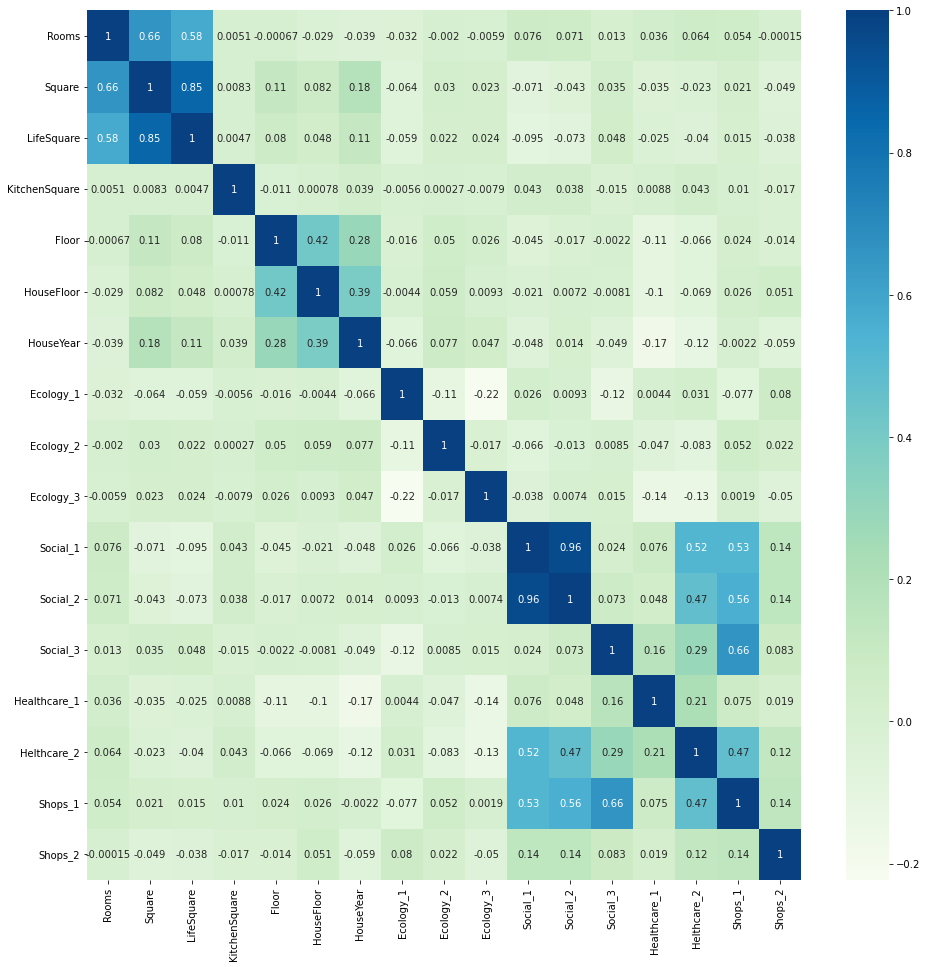

In [522]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.DataFrame(X_train, columns=fearute_names).corr(),annot=True, cmap='GnBu', xticklabels=True, yticklabels=True)
plt.show()

Видно, что наличие налиие объектов социального назначения, коррелирует с наличием объектов здравоохранения и бытового обслуживания, 
что в целом говорит о пропорциональном развитиее объектов - строятся одни, строятся и другие. Общая площадь , как главная компонента, которая отражает и жилую площадь и соответственно количество комнат. Также заметно , что этажность и год постройки коррелируют, так видимо дома более старые имеют меньше этажей. Исключим из признаков districtId, так как идентификатор района не подчеркивает близость к центру или престижность, если конечно идентфиикаторы не присваивали в порядке возрастания в зависимости от престижности или близости к центру.

In [523]:
from sklearn.model_selection import train_test_split

Разбиваем выборку на тестовую для проверки модели, и обучающую.

In [524]:
x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,test_size=0.30, random_state=42)

In [525]:
from sklearn.preprocessing import StandardScaler

Произведем масштабирование признаков

In [526]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)

In [527]:
x_test_scaled=scaler.transform(x_test)

Проводим трансформирование тестовой выборки

In [528]:
lr= LinearRegression(fit_intercept=True)

In [529]:
lr.fit(x_train_scaled,y_train)

LinearRegression()

Обучаем модель на тренировочной выборке

In [530]:

y_pred=lr.predict(x_test_scaled)

делаем предсказание для тестовой выборки

In [531]:
lr.coef_

array([ 26105.48245076,  39107.57132036,  -6615.80903379,    774.57178513,
         8899.0178592 ,   5553.94031011,  -1520.54200983,  -4196.40197096,
         4280.53518949,  -2391.15042782,  43952.27993423, -22954.4661144 ,
         6002.46578125,   8011.9045355 ,  10069.65283531,  -5898.991595  ,
         3524.44078163])

In [532]:
from sklearn.metrics import r2_score

Строим метрику r2 для провеки модели

In [533]:
r2= r2_score(y_test,y_pred)
r2

0.44985716881300797

Линейная регрессия описывает только 45% дисперсии целевого признака, что является плохим результатом

In [534]:
from sklearn.ensemble import RandomForestRegressor

Проверим другой тип регресии , случайный лес

In [535]:
clf=RandomForestRegressor(max_depth=12,n_estimators=1000, random_state=42, criterion='squared_error')
clf.fit(x_train_scaled,np.array(y_train))
y_pred=clf.predict(x_test_scaled)

In [536]:
r2= r2_score(y_test,y_pred)
r2

0.7144898614651956

RandomForestRegressor работает лучше так как  R2(RandomForestRegressor)>R2(LinearRegression)

In [537]:
clf.feature_importances_

array([0.07460829, 0.42236039, 0.03119084, 0.02500116, 0.02333209,
       0.01843119, 0.03329437, 0.04818239, 0.00063646, 0.00050847,
       0.09821461, 0.11044316, 0.06488085, 0.02320996, 0.00547561,
       0.01967696, 0.00055321])

Посмотрим нормализованные коеффициенты модели, и выведим их в порядке значимости.

In [538]:
sorted(list(zip(x_train.columns, clf.feature_importances_)), 
       key=lambda x: abs(x[1]), reverse=True)

[('Square', 0.42236038718391555),
 ('Social_2', 0.11044315820761094),
 ('Social_1', 0.0982146141574791),
 ('Rooms', 0.07460828535656952),
 ('Social_3', 0.06488084759810872),
 ('Ecology_1', 0.04818239466695367),
 ('HouseYear', 0.03329436942152191),
 ('LifeSquare', 0.031190837663714884),
 ('KitchenSquare', 0.025001162152258713),
 ('Floor', 0.02333208712940875),
 ('Healthcare_1', 0.023209955311427596),
 ('Shops_1', 0.019676961235206826),
 ('HouseFloor', 0.018431188780416417),
 ('Helthcare_2', 0.005475612286182858),
 ('Ecology_2', 0.0006364558122085373),
 ('Shops_2', 0.0005532129013667515),
 ('Ecology_3', 0.0005084701356493908)]

<AxesSubplot:>

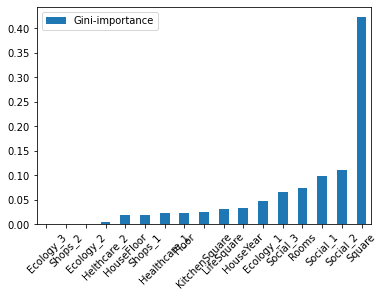

In [539]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

Видно, что большую роль в определении цены объекта вносит общая площадь, а также наличие социальной инфраструктуры.

In [540]:
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_validate


cv_results=cross_validate(lr, x_test_scaled,np.array(y_test),scoring = (
"r2",
"neg_median_absolute_error",
"neg_mean_absolute_error",
"neg_mean_absolute_percentage_error",
"neg_mean_squared_log_error",
"neg_root_mean_squared_error",
), return_estimator=True)
cv_results

{'fit_time': array([0.00388479, 0.00292015, 0.00199962, 0.00300097, 0.002002  ]),
 'score_time': array([0.00300407, 0.00199914, 0.00199938, 0.00203705, 0.00199962]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_r2': array([0.18530052, 0.5532633 , 0.44990674, 0.47327832, 0.47927799]),
 'test_neg_median_absolute_error': array([-34346.83675707, -28902.63274655, -30888.25419638, -32429.89841719,
        -29248.25572809]),
 'test_neg_mean_absolute_error': array([-49912.58760444, -44173.2486126 , -45677.06326467, -48418.19572085,
        -44268.4196901 ]),
 'test_neg_mean_absolute_percentage_error': array([-0.27024739, -0.22848152, -0.22559659, -0.26329471, -0.24033006]),
 'test_neg_mean_squared_log_error': array([-0.10646937, -0.08035448, -0.08437918, -0.10077289, -0.08740594]),
 'test_neg_root_mean_squared_error': array([-83537.96466651, -65005.88345813, -67789.96978416, -68312.68898307,
        -63349.01

Проведем кросс-валидацию по умолчмнию на 5 fold

In [541]:
rfc_fit_lr = cv_results['estimator']
print(rfc_fit_lr)

[LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]


In [542]:
y_pred=rfc_fit_lr[1].predict(x_test_scaled)

In [543]:
r2= r2_score(y_test,y_pred)
r2

0.4730788902300579

In [544]:


cv_results=cross_validate(clf, x_test_scaled,np.array(y_test),scoring = (
"r2",
"neg_median_absolute_error",
"neg_mean_absolute_error",
"neg_mean_absolute_percentage_error",
"neg_mean_squared_log_error",
"neg_root_mean_squared_error",
), return_estimator=True)
cv_results

{'fit_time': array([10.98555326, 10.73874688, 10.88564467, 10.85612416, 11.0815537 ]),
 'score_time': array([0.1509583 , 0.15203691, 0.14999151, 0.15299892, 0.15106821]),
 'estimator': [RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42),
  RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42),
  RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42),
  RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42),
  RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)],
 'test_r2': array([0.6235908 , 0.70780842, 0.64904627, 0.64885628, 0.67727657]),
 'test_neg_median_absolute_error': array([-17405.32547601, -16525.87326463, -18084.61432631, -18260.30209616,
        -17812.59089076]),
 'test_neg_mean_absolute_error': array([-32682.57961627, -31431.59414433, -32432.63035332, -33300.55064741,
        -30605.12199789]),
 'test_neg_mean_absolute_percentage_error': array([-0.18072246, -0.16272307, -0.1592468

In [545]:
rfc_fit_clf = cv_results['estimator']
print(rfc_fit_clf)

[RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42), RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42), RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42), RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42), RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)]


In [546]:
y_pred=rfc_fit_clf[1].predict(x_test_scaled)

In [547]:
r2= r2_score(y_test,y_pred)
r2

0.8731703168611022

In [548]:
RandomForestRegressor.feature_importances_

In [549]:
Y_test=rfc_fit_clf[1].predict(scaler.transform(X_test))

In [550]:
Y_test=pd.DataFrame(Y_test,columns=['Price'])

In [551]:
Y_test['Id']=test['Id']

In [552]:
Y_test.to_csv('price_csv.csv', encoding='utf8', header=True )